## Installation and Setup

In [1]:
!pip install librosa soundfile numpy pandas matplotlib seaborn scikit-learn xgboost imbalanced-learn joblib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import os

# Audio processing
import librosa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Supervised
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Machine Learning - Unsupervised
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            silhouette_score, adjusted_rand_score)

# Model persistence
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# Data Collection


### 2.1 Dataset Description
- **Source:** Custom audio emotion dataset
- **CSV File:** `speech_emotions.csv` containing metadata (set_id, text, gender, age, country)
- **Audio Files:** Located in `datasets/audio_files/{set_id}/` with 4 emotion variants per set
- **Emotion Labels:** euphoric, joyfully, sad, surprised
- **Total Samples:** 20 sets × 4 emotions = 80 audio samples


In [3]:
# Load the CSV file
df_metadata = pd.read_csv('./datasets/speech_emotions.csv')

# Display basic information
print("Dataset Shape:", df_metadata.shape)
print("\nColumn Names:", df_metadata.columns.tolist())
print("\nFirst 5 rows:")
print(df_metadata.head())
print("\nData Types:")
print(df_metadata.dtypes)
print("\nMissing Values:")
print(df_metadata.isnull().sum())

Dataset Shape: (20, 6)

Column Names: ['Unnamed: 0', 'set_id', 'text', 'gender', 'age', 'country']

First 5 rows:
   Unnamed: 0                                set_id  \
0           0  00026029e0--64991b6eef1fe70609d48edc   
1           1  00026029e0--64991b72e0daf97163c09c66   
2           2  00026029e0--64991b7fd94c0d5726dec353   
3           3  00026029e0--64991b907f82d9763944eba2   
4           4  00026029e0--64991bf2ffab6240f9f2418b   

                                                text  gender  age country  
0  The delicious aroma of freshly baked bread fil...    MALE   29      ZA  
1  I enjoy taking long walks in the peaceful coun...  FEMALE   42      NG  
2  The suspenseful novel kept me on the edge of m...  FEMALE   29      VN  
3  They celebrated their anniversary with a roman...  FEMALE   20      PK  
4  The diligent student earned top marks for her ...    MALE   30      PK  

Data Types:
Unnamed: 0     int64
set_id        object
text          object
gender        object
ag

## Build Complete Dataset

In [4]:
# Define emotion labels
emotion_labels = ['euphoric', 'joyfully', 'sad', 'surprised']

# Base directory for audio files
audio_base_dir = 'datasets/audio_files'

# Create dataset records
dataset_records = []

# Iterate through each set_id
for idx, row in df_metadata.iterrows():
    set_id = row['set_id']
    
    # For each emotion
    for emotion in emotion_labels:
        audio_path = os.path.join(audio_base_dir, set_id, f"{emotion}.wav")
        
        dataset_records.append({
            'set_id': set_id,
            'text': row['text'],
            'gender': row['gender'],
            'age': row['age'],
            'country': row['country'],
            'emotion': emotion,
            'audio_path': audio_path,
            'file_exists': os.path.exists(audio_path)
        })

# Create DataFrame
df_audio = pd.DataFrame(dataset_records)

# Display dataset summary
print(f"Total Audio Samples: {len(df_audio)}")
print(f"Files Found: {df_audio['file_exists'].sum()}")
print(f"Files Missing: {(~df_audio['file_exists']).sum()}")
print(f"\nEmotion Distribution:")
print(df_audio['emotion'].value_counts())
print(f"\nFirst few records:")
display(df_audio.head(10))

Total Audio Samples: 80
Files Found: 68
Files Missing: 12

Emotion Distribution:
emotion
euphoric     20
joyfully     20
sad          20
surprised    20
Name: count, dtype: int64

First few records:


,set_id,text,gender,age,country,emotion,audio_path,file_exists
0,00026029e0--64991b6eef1fe70609d48edc,The delicious aroma of freshly baked bread fil...,MALE,29,ZA,euphoric,datasets/audio_files/00026029e0--64991b6eef1fe...,True
1,00026029e0--64991b6eef1fe70609d48edc,The delicious aroma of freshly baked bread fil...,MALE,29,ZA,joyfully,datasets/audio_files/00026029e0--64991b6eef1fe...,True
2,00026029e0--64991b6eef1fe70609d48edc,The delicious aroma of freshly baked bread fil...,MALE,29,ZA,sad,datasets/audio_files/00026029e0--64991b6eef1fe...,True
3,00026029e0--64991b6eef1fe70609d48edc,The delicious aroma of freshly baked bread fil...,MALE,29,ZA,surprised,datasets/audio_files/00026029e0--64991b6eef1fe...,True
4,00026029e0--64991b72e0daf97163c09c66,I enjoy taking long walks in the peaceful coun...,FEMALE,42,NG,euphoric,datasets/audio_files/00026029e0--64991b72e0daf...,True
5,00026029e0--64991b72e0daf97163c09c66,I enjoy taking long walks in the peaceful coun...,FEMALE,42,NG,joyfully,datasets/audio_files/00026029e0--64991b72e0daf...,True
6,00026029e0--64991b72e0daf97163c09c66,I enjoy taking long walks in the peaceful coun...,FEMALE,42,NG,sad,datasets/audio_files/00026029e0--64991b72e0daf...,True
7,00026029e0--64991b72e0daf97163c09c66,I enjoy taking long walks in the peaceful coun...,FEMALE,42,NG,surprised,datasets/audio_files/00026029e0--64991b72e0daf...,True
8,00026029e0--64991b7fd94c0d5726dec353,The suspenseful novel kept me on the edge of m...,FEMALE,29,VN,euphoric,datasets/audio_files/00026029e0--64991b7fd94c0...,True
9,00026029e0--64991b7fd94c0d5726dec353,The suspenseful novel kept me on the edge of m...,FEMALE,29,VN,joyfully,datasets/audio_files/00026029e0--64991b7fd94c0...,True


## Data Exploration and Preparation

### Metadata Analysis

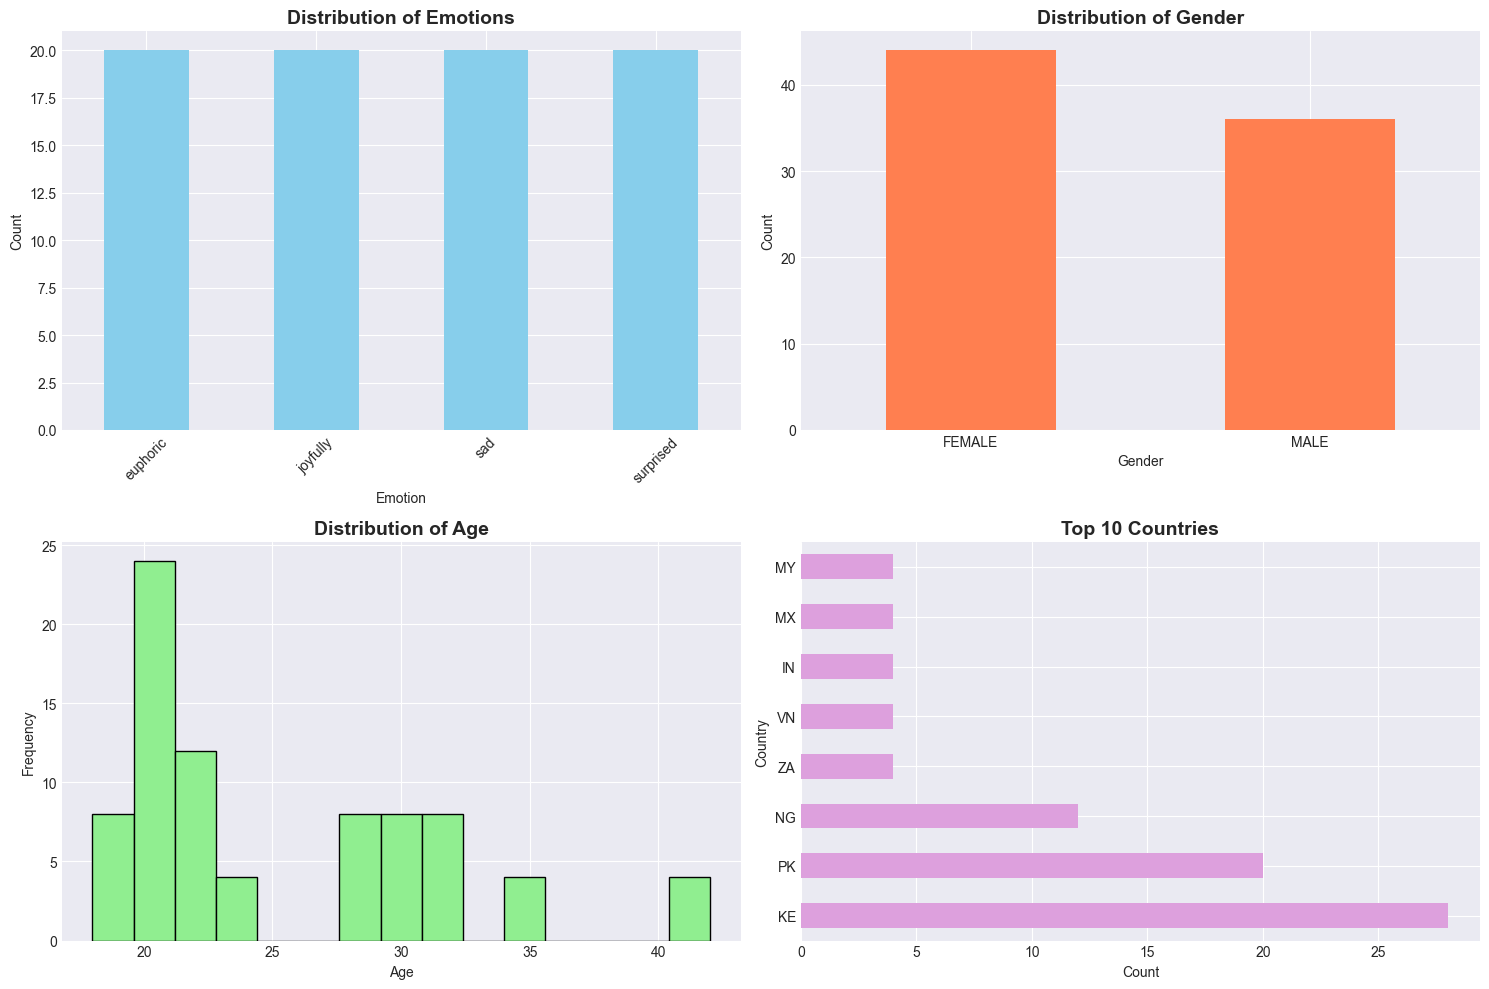

In [5]:
# Create visualization subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Emotion distribution
df_audio['emotion'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Emotions', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Emotion')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Gender distribution
df_audio['gender'].value_counts().plot(kind='bar', ax=axes[0, 1], color='coral')
axes[0, 1].set_title('Distribution of Gender', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# Plot 3: Age distribution
axes[1, 0].hist(df_audio['age'], bins=15, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Age', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Age')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Country distribution (top 10)
top_countries = df_audio['country'].value_counts().head(10)
top_countries.plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('Top 10 Countries', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Count')
axes[1, 1].set_ylabel('Country')

plt.tight_layout()
plt.savefig('eda_metadata.png', dpi=300, bbox_inches='tight')
plt.show()


### Feature Extraction

In [6]:
def extract_audio_features(audio_path, sr=22050):
    try:
        # Load audio file
        y, sr = librosa.load(audio_path, sr=sr)
        
        # Extract features
        features = {}
        
        # 1. MFCCs (13 coefficients) - captures timbre
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features['mfcc_mean'] = np.mean(mfccs, axis=1)
        features['mfcc_std'] = np.std(mfccs, axis=1)
        
        # 2. Chroma features - captures pitch content
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)
        
        # 3. Spectral centroid - center of mass of spectrum
        spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
        features['spectral_centroid_mean'] = np.mean(spectral_centroids)
        features['spectral_centroid_std'] = np.std(spectral_centroids)
        
        # 4. Spectral rolloff - frequency below which 85% of energy is contained
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
        features['spectral_rolloff_std'] = np.std(spectral_rolloff)
        
        # 5. Zero crossing rate - speech/music discrimination
        zcr = librosa.feature.zero_crossing_rate(y)
        features['zcr_mean'] = np.mean(zcr)
        features['zcr_std'] = np.std(zcr)
        
        # 6. RMS Energy - overall loudness
        rms = librosa.feature.rms(y=y)
        features['rms_mean'] = np.mean(rms)
        features['rms_std'] = np.std(rms)
        
        # 7. Tempo - rhythmic content
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        features['tempo'] = tempo
        
        # Flatten all features into a single vector
        feature_vector = []
        for key in sorted(features.keys()):
            val = features[key]
            if isinstance(val, np.ndarray):
                feature_vector.extend(val.tolist())
            else:
                feature_vector.append(val)
        
        return feature_vector, True
    
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None, False

print("Feature extraction function defined")

# Test on one file to get feature dimensions
sample_files = df_audio[df_audio['file_exists'] == True]['audio_path'].values
if len(sample_files) > 0:
    test_features, success = extract_audio_features(sample_files[0])
    if success:
        print(f"\nFeature vector dimension: {len(test_features)}")
        print("Feature extraction successful!")
else:
    print("\n No audio files found. Please ensure audio files are in the correct directory.")

Feature extraction function defined

Feature vector dimension: 59
Feature extraction successful!


### Extract Feature for all Audio Files

In [12]:
# Extract features for all audio files
print("Extracting features from all audio files...\n")

features_list = []
labels_list = []
metadata_list = []
successful_extractions = 0
failed_extractions = 0

for idx, row in df_audio.iterrows():
    if row['file_exists']:
        features, success = extract_audio_features(row['audio_path'])
        
        if success:
            features_list.append(features)
            labels_list.append(row['emotion'])
            metadata_list.append({
                'set_id': row['set_id'],
                'gender': row['gender'],
                'age': row['age'],
                'country': row['country']
            })
            successful_extractions += 1
        else:
            failed_extractions += 1
    else:
        failed_extractions += 1
    
    # Progress indicator
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(df_audio)} files...")

# Convert to numpy arrays
X = np.array(features_list)
y = np.array(labels_list)

print(f"\n{'='*60}")
print(f"Feature Extraction Complete!")
print(f"{'='*60}")
print(f"✓ Successfully extracted: {successful_extractions} files")
print(f"✗ Failed extractions: {failed_extractions} files")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for emotion, count in zip(unique, counts):
    print(f"  {emotion}: {count}")

Extracting features from all audio files...

Processed 20/80 files...
Processed 40/80 files...
Processed 60/80 files...
Processed 80/80 files...

Feature Extraction Complete!
✓ Successfully extracted: 68 files
✗ Failed extractions: 12 files

Feature matrix shape: (68, 59)
Labels shape: (68,)

Class distribution:
  euphoric: 17
  joyfully: 17
  sad: 17
  surprised: 17


### Visualize Audio Waves

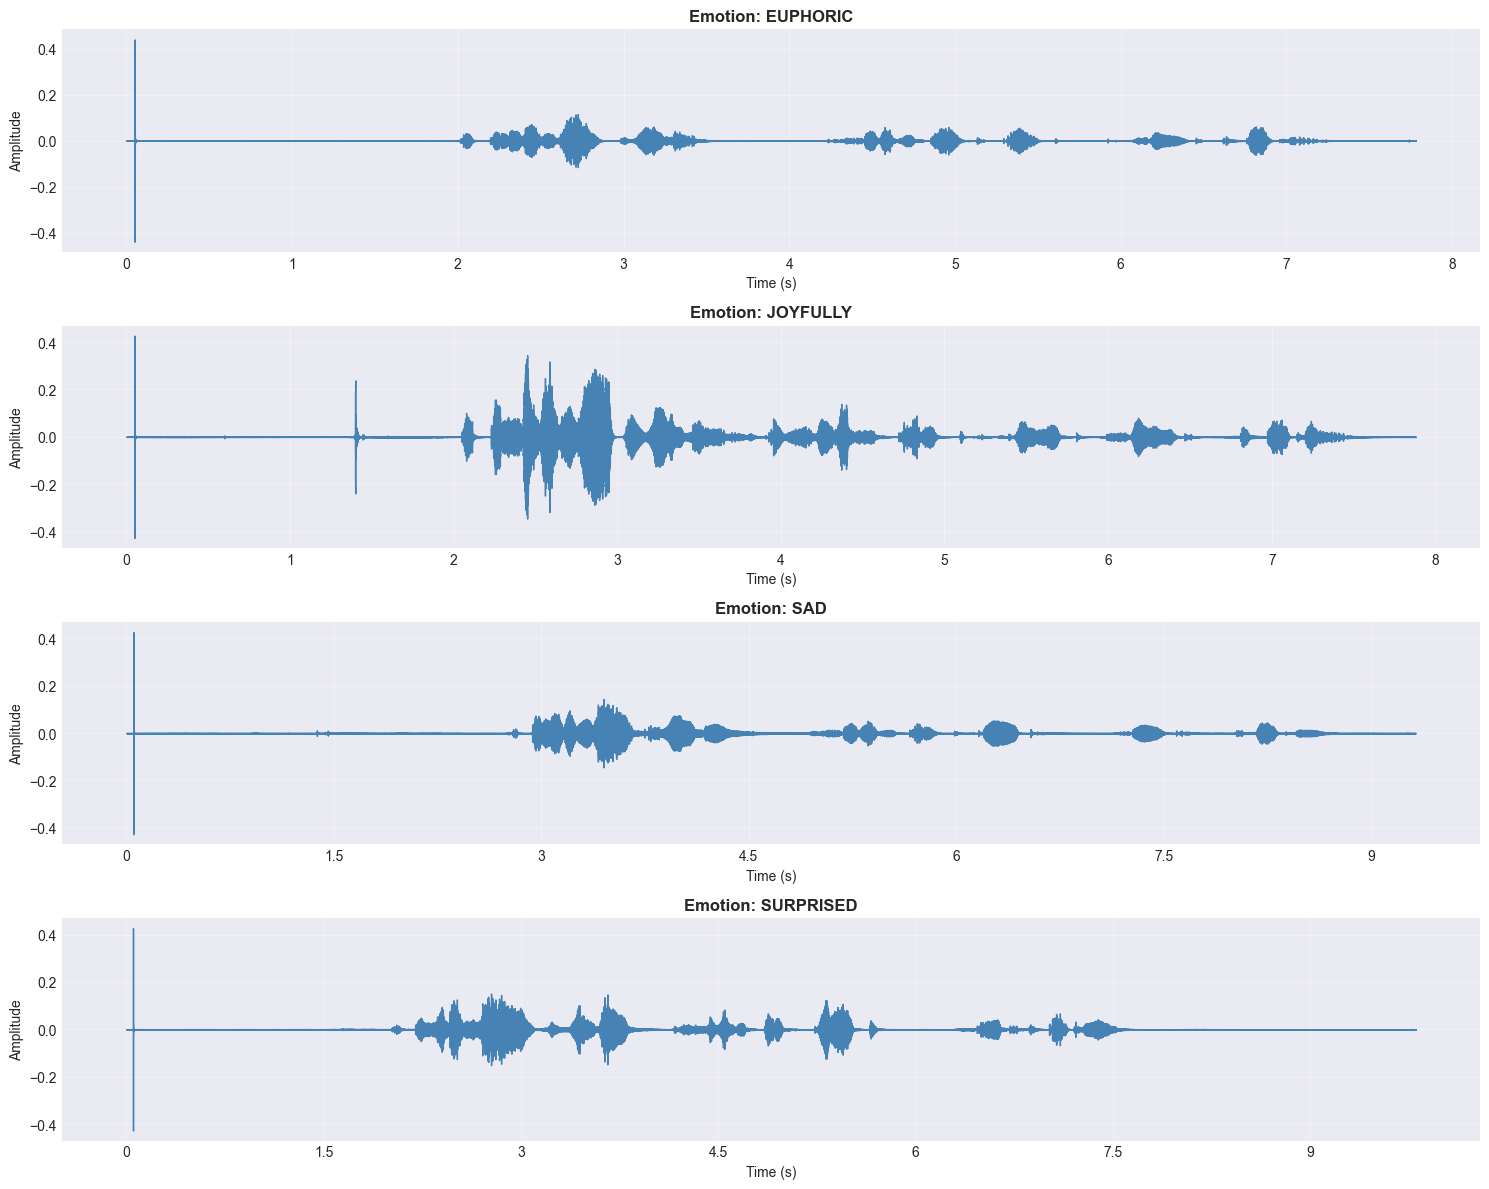

Audio waveform visualizations created


In [13]:
if successful_extractions > 0:
    first_set_id = df_audio['set_id'].iloc[0]
    sample_files = df_audio[df_audio['set_id'] == first_set_id]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    for idx, (_, row) in enumerate(sample_files.iterrows()):
        if row['file_exists']:
            y_wave, sr = librosa.load(row['audio_path'])
            
            librosa.display.waveshow(y_wave, sr=sr, ax=axes[idx], color='steelblue')
            axes[idx].set_title(f"Emotion: {row['emotion'].upper()}", 
                               fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Time (s)')
            axes[idx].set_ylabel('Amplitude')
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('audio_waveforms.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Audio waveform visualizations created")
else:
    print("Cannot visualize waveforms - no audio files found")

## Data Cleaning

In [14]:
# Check for missing values in feature matrix
print("Checking for missing values in features...")
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()

print(f"NaN values: {nan_count}")
print(f"Inf values: {inf_count}")

# Replace NaN and Inf with feature means
if nan_count > 0 or inf_count > 0:
    print("\nCleaning data...")
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print("Data cleaned")
else:
    print("No missing or infinite values found")

# Check for duplicates
unique_samples = len(np.unique(X, axis=0))
print(f"\nTotal samples: {len(X)}")
print(f"Unique samples: {unique_samples}")
if unique_samples < len(X):
    print(f"Found {len(X) - unique_samples} duplicate samples")
else:
    print("No duplicates found")

Checking for missing values in features...
NaN values: 0
Inf values: 0
No missing or infinite values found

Total samples: 68
Unique samples: 68
No duplicates found


### Outlier Visualization

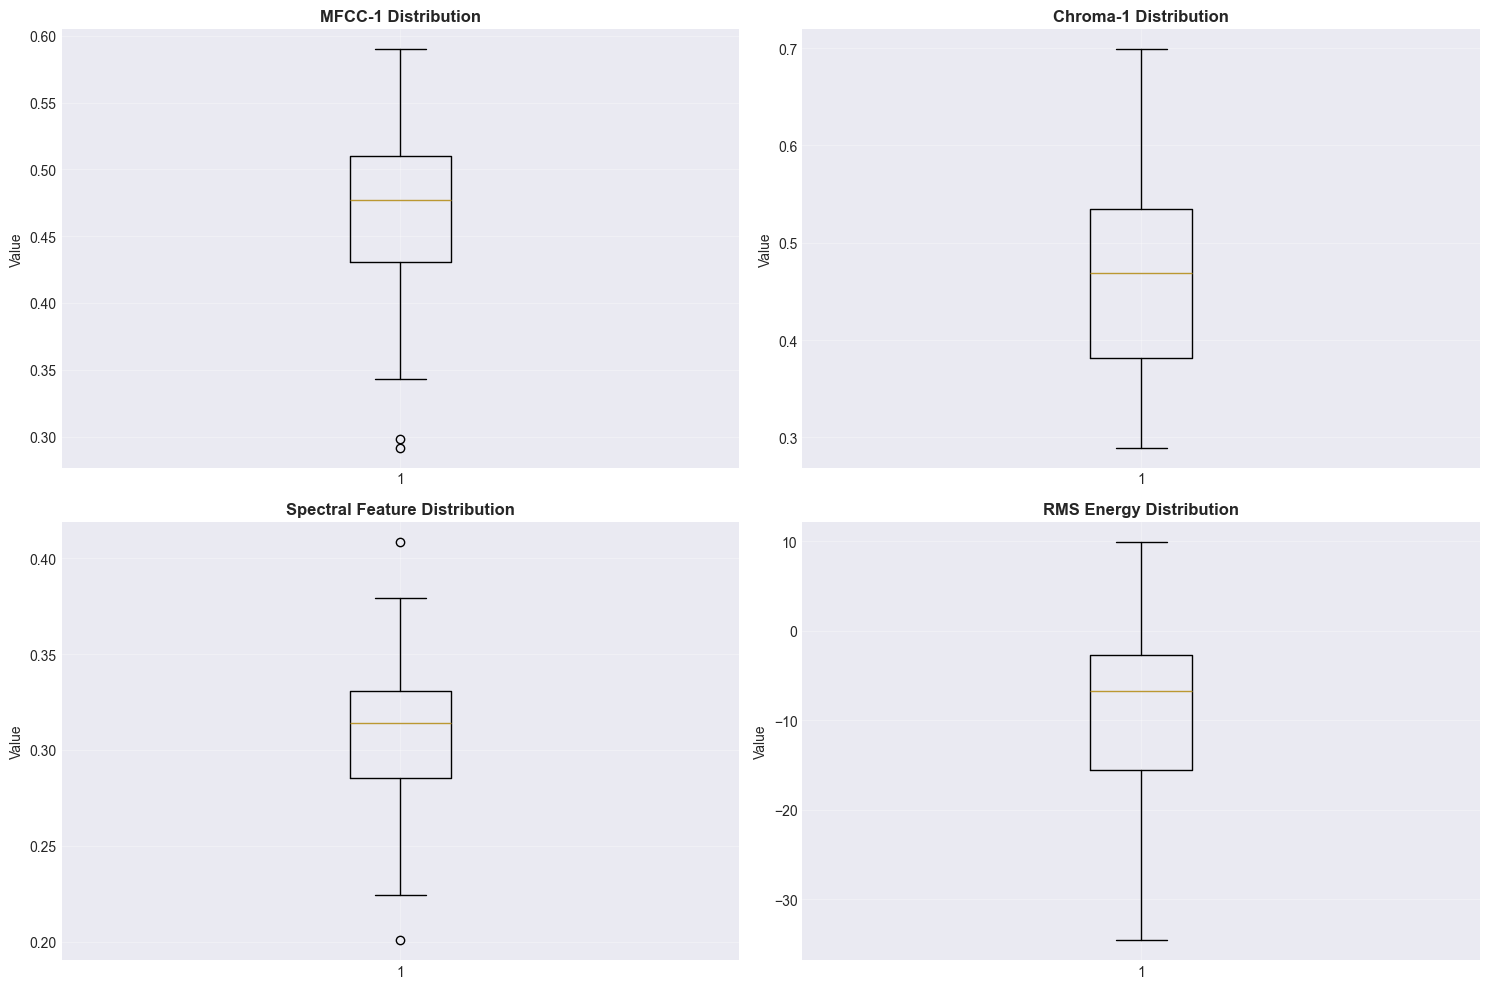

Outlier visualization created

Note: Outliers are preserved as they may contain important emotion-specific information


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

feature_indices = [0, 10, 20, 30]  # Sample features
feature_names = ['MFCC-1', 'Chroma-1', 'Spectral Feature', 'RMS Energy']

for idx, (feat_idx, feat_name) in enumerate(zip(feature_indices, feature_names)):
    if feat_idx < X.shape[1]:
        ax = axes[idx // 2, idx % 2]
        ax.boxplot(X[:, feat_idx])
        ax.set_title(f'{feat_name} Distribution', fontsize=12, fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_outliers.png', dpi=300, bbox_inches='tight')
plt.show()

print("Outlier visualization created")
print("\nNote: Outliers are preserved as they may contain important emotion-specific information")

### Feature Engineering

In [16]:
# Encode emotion labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Emotion Label Encoding:")
print("="*40)
for idx, emotion in enumerate(label_encoder.classes_):
    print(f"{emotion:15} -> {idx}")

print(f"\nEncoded labels shape: {y_encoded.shape}")
print(f"Unique classes: {len(label_encoder.classes_)}")

Emotion Label Encoding:
euphoric        -> 0
joyfully        -> 1
sad             -> 2
surprised       -> 3

Encoded labels shape: (68,)
Unique classes: 4


In [17]:
# Feature Scaling
# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform features
X_scaled = scaler.fit_transform(X)

print("Feature Scaling Complete")
print("="*40)
print(f"Original feature range:")
print(f"Min: {X.min():.4f}")
print(f"Max: {X.max():.4f}")
print(f"Mean: {X.mean():.4f}")
print(f"Std: {X.std():.4f}")
print(f"\nScaled feature range:")
print(f"Min: {X_scaled.min():.4f}")
print(f"Max: {X_scaled.max():.4f}")
print(f"Mean: {X_scaled.mean():.4f}")
print(f"Std: {X_scaled.std():.4f}")

Feature Scaling Complete
Original feature range:
Min: -576.1407
Max: 8391.8677
Mean: 208.8439
Std: 950.7361

Scaled feature range:
Min: -3.7016
Max: 4.9649
Mean: 0.0000
Std: 1.0000


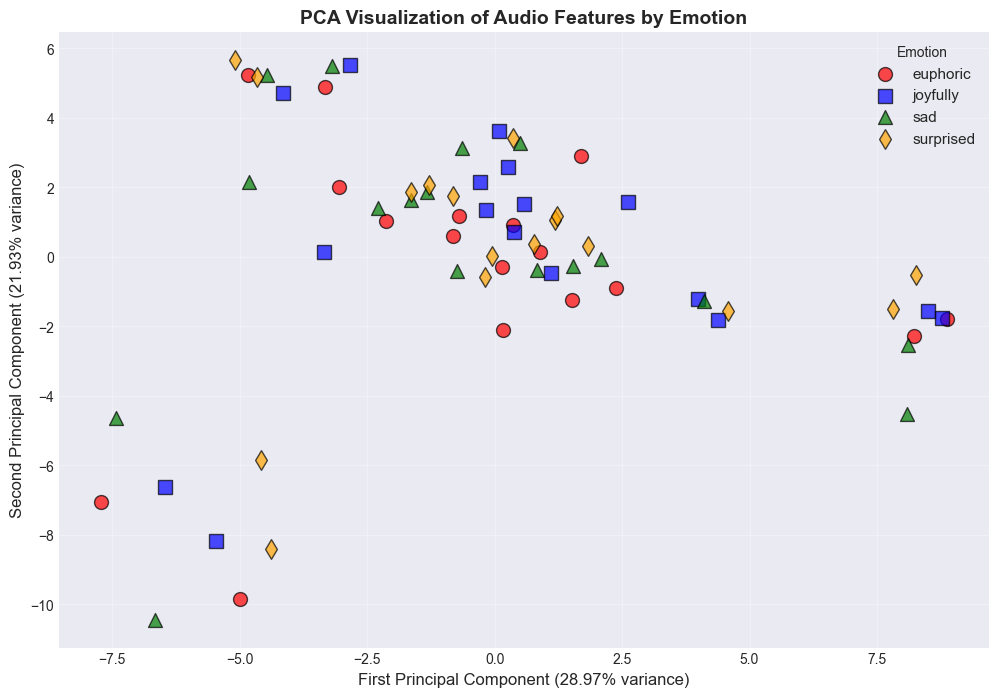

✓ PCA visualization created

Total variance explained by 2 components: 50.90%


In [18]:
# Apply PCA to visualize data in 2D

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
colors = ['red', 'blue', 'green', 'orange']
markers = ['o', 's', '^', 'd']

for idx, emotion in enumerate(label_encoder.classes_):
    mask = y_encoded == idx  
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colors[idx], marker=markers[idx], 
               label=emotion, alpha=0.7, s=100, edgecolors='black')

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)', 
          fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)', 
          fontsize=12)
plt.title('PCA Visualization of Audio Features by Emotion', 
         fontsize=14, fontweight='bold')
plt.legend(title='Emotion', fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig('pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ PCA visualization created")
print(f"\nTotal variance explained by 2 components: {pca.explained_variance_ratio_.sum():.2%}")


### Data Splitting

In [19]:
# First split: separate test set (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_encoded
)

# Second split: separate validation set from training (15% of total or train_val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size=0.176, 
    random_state=42, 
    stratify=y_train_val
)

print("Data Splitting Complete")
print("="*60)
print(f"Total samples: {len(X_scaled)}")
print(f"\nTraining set:   {len(X_train)} samples ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X_scaled)*100:.1f}%)")
print(f"Test set:       {len(X_test)} samples ({len(X_test)/len(X_scaled)*100:.1f}%)")

# Verify class distribution
print(f"\nClass Distribution in Training Set:")
for idx, emotion in enumerate(label_encoder.classes_):
    count = (y_train == idx).sum()
    print(f"  {emotion:15} {count:3} samples ({count/len(y_train)*100:.1f}%)")

print(f"\nClass Distribution in Validation Set:")
for idx, emotion in enumerate(label_encoder.classes_):
    count = (y_val == idx).sum()
    print(f"  {emotion:15} {count:3} samples ({count/len(y_val)*100:.1f}%)")

print(f"\nClass Distribution in Test Set:")
for idx, emotion in enumerate(label_encoder.classes_):
    count = (y_test == idx).sum()
    print(f"  {emotion:15} {count:3} samples ({count/len(y_test)*100:.1f}%)")

Data Splitting Complete
Total samples: 68

Training set:   46 samples (67.6%)
Validation set: 11 samples (16.2%)
Test set:       11 samples (16.2%)

Class Distribution in Training Set:
  euphoric         12 samples (26.1%)
  joyfully         12 samples (26.1%)
  sad              11 samples (23.9%)
  surprised        11 samples (23.9%)

Class Distribution in Validation Set:
  euphoric          2 samples (18.2%)
  joyfully          3 samples (27.3%)
  sad               3 samples (27.3%)
  surprised         3 samples (27.3%)

Class Distribution in Test Set:
  euphoric          3 samples (27.3%)
  joyfully          2 samples (18.2%)
  sad               3 samples (27.3%)
  surprised         3 samples (27.3%)


### Model Development and Training

#### Supervised Learning

In [20]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

print("Initialized Models:")
print("="*60)
for name, model in models.items():
    print(f"{name}")

Initialized Models:
Random Forest
SVM
Gradient Boosting
KNN
Logistic Regression


In [21]:
# Train and evaluate each model
results = {}
trained_models = {}

print("Training and Evaluating Models...\n")
print("="*80)

for name, model in models.items():
    print(f"\n Training {name}...")
    
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
    recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_val, y_val_pred, average='weighted', zero_division=0)
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_val_pred
    }
    
    trained_models[name] = model
    
    print(f" {name} Training Complete")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

print("\n" + "="*80)
print("All models trained successfully!")

Training and Evaluating Models...


 Training Random Forest...
 Random Forest Training Complete
  Accuracy:  0.0909
  Precision: 0.0909
  Recall:    0.0909
  F1-Score:  0.0909

 Training SVM...
 SVM Training Complete
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

 Training Gradient Boosting...
 Gradient Boosting Training Complete
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

 Training KNN...
 KNN Training Complete
  Accuracy:  0.0000
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

 Training Logistic Regression...
 Logistic Regression Training Complete
  Accuracy:  0.0909
  Precision: 0.0364
  Recall:    0.0909
  F1-Score:  0.0519

All models trained successfully!


### Compare Model Performance


Model Performance Comparison (Validation Set)
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.090909   0.090909 0.090909  0.090909
Logistic Regression  0.090909   0.036364 0.090909  0.051948
                SVM  0.000000   0.000000 0.000000  0.000000
  Gradient Boosting  0.000000   0.000000 0.000000  0.000000
                KNN  0.000000   0.000000 0.000000  0.000000


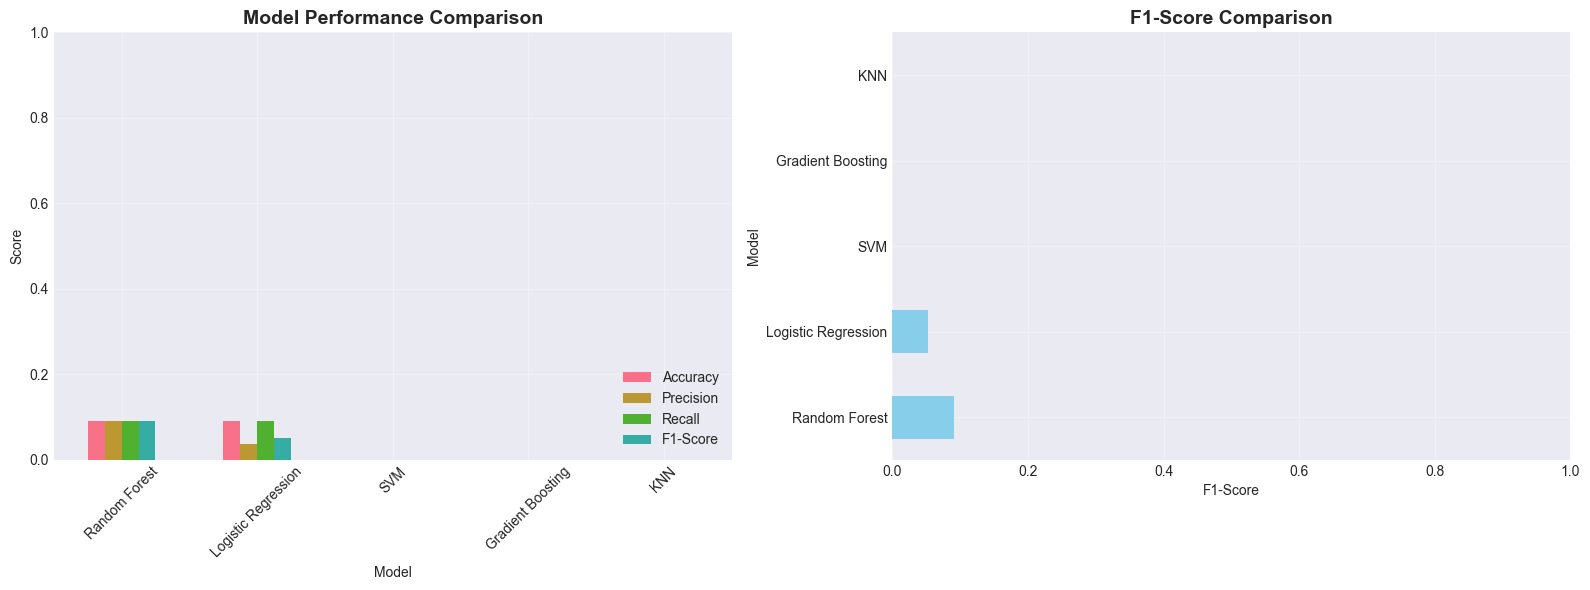


 Best Model: Random Forest
   F1-Score: 0.0909


In [23]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\nModel Performance Comparison (Validation Set)")
print("="*80)
print(comparison_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

comparison_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# F1-Score comparison
comparison_df.plot(x='Model', y='F1-Score', kind='barh', ax=axes[1], 
                  legend=False, color='skyblue')
axes[1].set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('F1-Score')
axes[1].set_xlim([0, 1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")

#### Unsupervised Learning

In [24]:
# K-Means clustering
print("Training Unsupervised Learning Models...\n")
print("="*60)

# K-Means with k=4 (number of emotions)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)

ari_kmeans = adjusted_rand_score(y_encoded, clusters_kmeans)

print("K-Means Clustering Results:")
print(f"  Silhouette Score: {silhouette_kmeans:.4f}")
print(f"  Adjusted Rand Index: {ari_kmeans:.4f}")
print(f"\nCluster Distribution:")
unique_clusters, cluster_counts = np.unique(clusters_kmeans, return_counts=True)
for cluster, count in zip(unique_clusters, cluster_counts):
    print(f"  Cluster {cluster}: {count} samples")

Training Unsupervised Learning Models...

K-Means Clustering Results:
  Silhouette Score: 0.2221
  Adjusted Rand Index: -0.0269

Cluster Distribution:
  Cluster 0: 8 samples
  Cluster 1: 36 samples
  Cluster 2: 11 samples
  Cluster 3: 13 samples


In [25]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
clusters_hierarchical = hierarchical.fit_predict(X_scaled)

# Evaluate
silhouette_hierarchical = silhouette_score(X_scaled, clusters_hierarchical)
ari_hierarchical = adjusted_rand_score(y_encoded, clusters_hierarchical)

print("\nHierarchical Clustering Results:")
print(f"  Silhouette Score: {silhouette_hierarchical:.4f}")
print(f"  Adjusted Rand Index: {ari_hierarchical:.4f}")
print(f"\nCluster Distribution:")
unique_clusters, cluster_counts = np.unique(clusters_hierarchical, return_counts=True)
for cluster, count in zip(unique_clusters, cluster_counts):
    print(f"  Cluster {cluster}: {count} samples")


Hierarchical Clustering Results:
  Silhouette Score: 0.2357
  Adjusted Rand Index: -0.0303

Cluster Distribution:
  Cluster 0: 12 samples
  Cluster 1: 8 samples
  Cluster 2: 40 samples
  Cluster 3: 8 samples


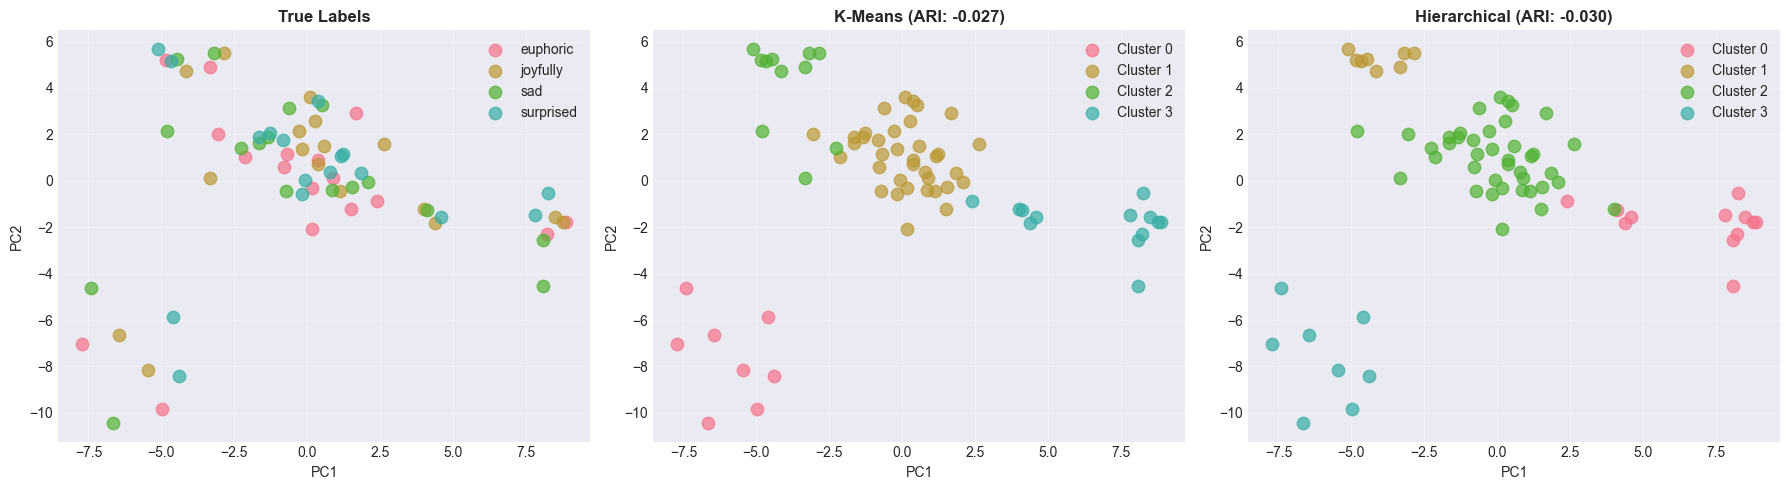


 Clustering visualizations created


In [26]:
# Visualize clustering results using PCA
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# labels
for idx, emotion in enumerate(label_encoder.classes_):
    mask = y_encoded == idx
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=emotion, alpha=0.7, s=80)
axes[0].set_title('True Labels', fontsize=12, fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# K-Means clusters
for cluster in range(4):
    mask = clusters_kmeans == cluster
    axes[1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster}', alpha=0.7, s=80)
axes[1].set_title(f'K-Means (ARI: {ari_kmeans:.3f})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Hierarchical clusters
for cluster in range(4):
    mask = clusters_hierarchical == cluster
    axes[2].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   label=f'Cluster {cluster}', alpha=0.7, s=80)
axes[2].set_title(f'Hierarchical (ARI: {ari_hierarchical:.3f})', 
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Clustering visualizations created")

In [28]:
print("\n" + "="*80)
print("SUPERVISED vs UNSUPERVISED LEARNING COMPARISON")
print("="*80)

print(f"\n Best Supervised Model: {best_model_name}")
print(f"   Accuracy:  {results[best_model_name]['accuracy']:.4f}")
print(f"   F1-Score:  {results[best_model_name]['f1_score']:.4f}")

print(f"\n Best Unsupervised Model: K-Means")
print(f"   Silhouette Score: {silhouette_kmeans:.4f}")
print(f"   Adjusted Rand Index: {ari_kmeans:.4f}")

print("\n Recommendation: Use SUPERVISED LEARNING since we have labeled data")


SUPERVISED vs UNSUPERVISED LEARNING COMPARISON

 Best Supervised Model: Random Forest
   Accuracy:  0.0909
   F1-Score:  0.0909

 Best Unsupervised Model: K-Means
   Silhouette Score: 0.2221
   Adjusted Rand Index: -0.0269

 Recommendation: Use SUPERVISED LEARNING since we have labeled data


## Model Evaluation and Hyperparameter Tuning



In [30]:
# Perform cross-validation on best model
print(f"Performing 5-Fold Cross-Validation on {best_model_name}...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1_weighted')

print("Cross-Validation Results:")
print("="*60)
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print("\nSummary Statistics:")
print(f" Mean F1-Score: {cv_scores.mean():.4f}")
print(f" Std Deviation: {cv_scores.std():.4f}")
print(f" Min F1-Score:  {cv_scores.min():.4f}")
print(f" Max F1-Score:  {cv_scores.max():.4f}")

Performing 5-Fold Cross-Validation on Random Forest...

Cross-Validation Results:
Fold 1: 0.0500
Fold 2: 0.3889
Fold 3: 0.0000
Fold 4: 0.1333
Fold 5: 0.0000

Summary Statistics:
 Mean F1-Score: 0.1144
 Std Deviation: 0.1456
 Min F1-Score:  0.0000
 Max F1-Score:  0.3889


### Hyperparameter Tuning with GridSearchCV

In [31]:
print(f"\nPerforming Hyperparameter Tuning for {best_model_name}...\n")

param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [1000, 2000]
    }
}

param_grid = param_grids[best_model_name]

grid_search = GridSearchCV(
    estimator=models[best_model_name],
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nHyperparameter Tuning Results:")
print("="*60)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best CV F1-Score: {grid_search.best_score_:.4f}")

best_model_tuned = grid_search.best_estimator_


Performing Hyperparameter Tuning for Random Forest...

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Hyperparameter Tuning Results:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1-Score: 0.2116


In [32]:
# Evaluate tuned model
y_val_pred_tuned = best_model_tuned.predict(X_val)

accuracy_tuned = accuracy_score(y_val, y_val_pred_tuned)
precision_tuned = precision_score(y_val, y_val_pred_tuned, average='weighted', zero_division=0)
recall_tuned = recall_score(y_val, y_val_pred_tuned, average='weighted', zero_division=0)
f1_tuned = f1_score(y_val, y_val_pred_tuned, average='weighted', zero_division=0)

print("\nTuned Model Performance on Validation Set:")
print("="*60)
print(f"Accuracy:  {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall:    {recall_tuned:.4f}")
print(f"F1-Score:  {f1_tuned:.4f}")

# Compare with original model
print("\nImprovement Analysis:")
print("="*60)
original_f1 = results[best_model_name]['f1_score']
improvement = f1_tuned - original_f1
print(f"Original F1-Score:    {original_f1:.4f}")
print(f"Tuned F1-Score:       {f1_tuned:.4f}")
print(f"Improvement:          {improvement:+.4f} ({improvement/original_f1*100:+.2f}%)")


Tuned Model Performance on Validation Set:
Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000

Improvement Analysis:
Original F1-Score:    0.0909
Tuned F1-Score:       0.0000
Improvement:          -0.0909 (-100.00%)


### Confusion Matrix and Classification Report

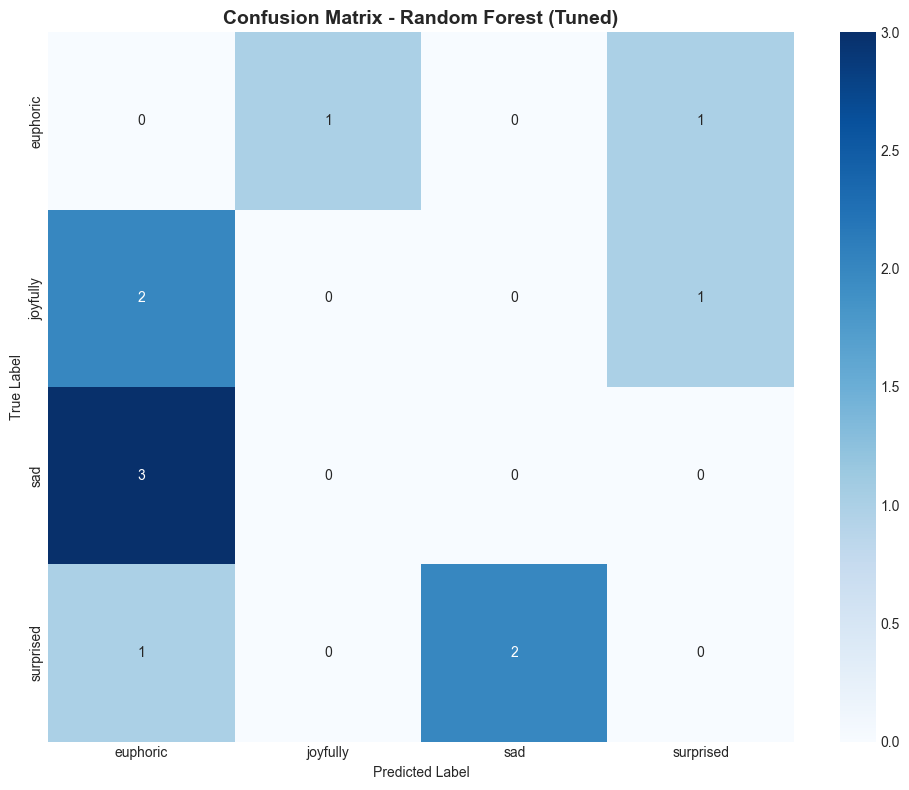


Detailed Classification Report:
              precision    recall  f1-score   support

    euphoric     0.0000    0.0000    0.0000       2.0
    joyfully     0.0000    0.0000    0.0000       3.0
         sad     0.0000    0.0000    0.0000       3.0
   surprised     0.0000    0.0000    0.0000       3.0

    accuracy                         0.0000      11.0
   macro avg     0.0000    0.0000    0.0000      11.0
weighted avg     0.0000    0.0000    0.0000      11.0



In [33]:
# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred_tuned)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name} (Tuned)', 
         fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate classification report
print("\nDetailed Classification Report:")
print("="*80)
print(classification_report(y_val, y_val_pred_tuned, 
                          target_names=label_encoder.classes_,
                          digits=4))

In [36]:
# Evaluate on training set to check for overfitting
y_train_pred = best_model_tuned.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

print("Overfitting/Underfitting Analysis:")
print("="*60)
print(f"Training F1-Score:   {train_f1:.4f}")
print(f"Validation F1-Score: {f1_tuned:.4f}")
print(f"Difference:          {train_f1 - f1_tuned:.4f}")

if train_f1 - f1_tuned > 0.10:
    print("\n Overfitted")
elif f1_tuned < 0.60:
    print("\n Underfitted")
else:
    print("\n Model shows good generalization")

Overfitting/Underfitting Analysis:
Training F1-Score:   1.0000
Validation F1-Score: 0.0000
Difference:          1.0000

 Overfitted


### Model Testing and Deployment

Final Model Evaluation on Test Set

 Final Test Set Performance:
Model:     Random Forest
Accuracy:  0.0909 
Precision: 0.0455
Recall:    0.0909
F1-Score:  0.0606 

 Success Criteria Check:
Accuracy > 70%:   ✗ NOT MET
F1-Score > 0.65:  ✗ NOT MET


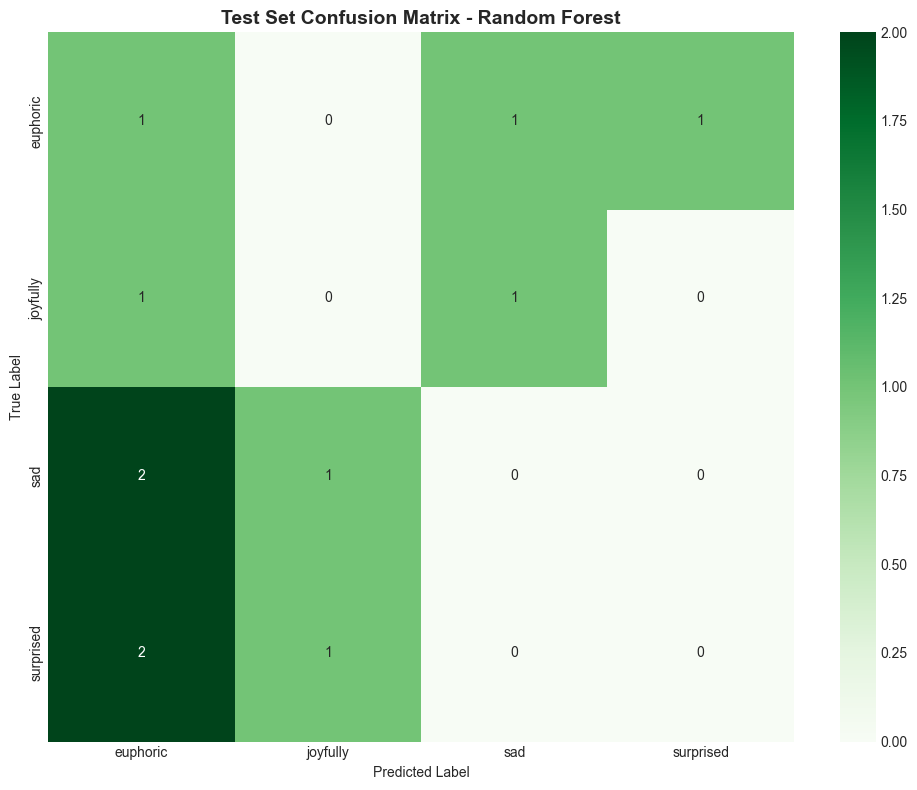


Test Set Classification Report:
              precision    recall  f1-score   support

    euphoric     0.1667    0.3333    0.2222         3
    joyfully     0.0000    0.0000    0.0000         2
         sad     0.0000    0.0000    0.0000         3
   surprised     0.0000    0.0000    0.0000         3

    accuracy                         0.0909        11
   macro avg     0.0417    0.0833    0.0556        11
weighted avg     0.0455    0.0909    0.0606        11



In [37]:
print("Final Model Evaluation on Test Set")
print("="*80)

y_test_pred = best_model_tuned.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

print(f"\n Final Test Set Performance:")
print("="*60)
print(f"Model:     {best_model_name}")
print(f"Accuracy:  {test_accuracy:.4f} {'✓' if test_accuracy > 0.70 else ''}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f} {'✓' if test_f1 > 0.65 else ''}")

# Success criteria check
print("\n Success Criteria Check:")
print("="*60)
accuracy_met = "✓ MET" if test_accuracy > 0.70 else "✗ NOT MET"
f1_met = "✓ MET" if test_f1 > 0.65 else "✗ NOT MET"
print(f"Accuracy > 70%:   {accuracy_met}")
print(f"F1-Score > 0.65:  {f1_met}")

# Generate test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Test Set Confusion Matrix - {best_model_name}', 
         fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_test.png', dpi=300, bbox_inches='tight')
plt.show()

# Test set classification report
print("\nTest Set Classification Report:")
print("="*80)
print(classification_report(y_test, y_test_pred, 
                          target_names=label_encoder.classes_,
                          digits=4))

In [38]:
os.makedirs('models', exist_ok=True)

model_filename = f'models/audio_emotion_classifier_{best_model_name.replace(" ", "_").lower()}.pkl'
joblib.dump(best_model_tuned, model_filename)

scaler_filename = 'models/feature_scaler.pkl'
joblib.dump(scaler, scaler_filename)

encoder_filename = 'models/label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)

print("Model Artifacts Saved:")
print("="*60)
print(f"Model:         {model_filename}")
print(f"Scaler:        {scaler_filename}")
print(f"Label Encoder: {encoder_filename}")

print("\nVerifying saved models...")
loaded_model = joblib.load(model_filename)
loaded_scaler = joblib.load(scaler_filename)
loaded_encoder = joblib.load(encoder_filename)

test_pred = loaded_model.predict(X_test)
test_accuracy_loaded = accuracy_score(y_test, test_pred)

print(f"\n Models loaded successfully")
print(f" Loaded model accuracy: {test_accuracy_loaded:.4f}")
print(f" Matches original: {test_accuracy_loaded == test_accuracy}")

Model Artifacts Saved:
Model:         models/audio_emotion_classifier_random_forest.pkl
Scaler:        models/feature_scaler.pkl
Label Encoder: models/label_encoder.pkl

Verifying saved models...

 Models loaded successfully
 Loaded model accuracy: 0.0909
 Matches original: True


In [39]:
def predict_emotion(audio_path, model, scaler, label_encoder):
    features, success = extract_audio_features(audio_path)
    
    if not success:
        return None, None
    
    # Reshape and scale features
    features = np.array(features).reshape(1, -1)
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction_encoded = model.predict(features_scaled)[0]
    prediction = label_encoder.inverse_transform([prediction_encoded])[0]
    
    # Get probabilities if available
    probabilities = None
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(features_scaled)[0]
        probabilities = dict(zip(label_encoder.classes_, proba))
    
    return prediction, probabilities


In [ ]:
# Test prediction on a sample file
if successful_extractions > 0:
    # Get a random test sample
    test_samples = df_audio[df_audio['file_exists'] == True].sample(4, random_state=42)
    
    print("Testing Prediction Function:")
    print("="*80)
    
    for idx, row in test_samples.iterrows():
        prediction, probabilities = predict_emotion(
            row['audio_path'], 
            loaded_model, 
            loaded_scaler, 
            loaded_encoder
        )
        
        print(f"\nFile: {os.path.basename(row['audio_path'])}")
        print(f"True Emotion:      {row['emotion']}")
        print(f"Predicted Emotion: {prediction}")
        print(f"Correct: {'✓' if prediction == row['emotion'] else '✗'}")
        
        if probabilities:
            print(f"\nPrediction Probabilities:")
            for emotion, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
                print(f"  {emotion:12} {prob:.4f} {'█' * int(prob * 50)}")
    
    print("\n" + "="*80)
    print("Prediction function works correctly")
else:
    print(" No audio files available for testing")
    

Testing Prediction Function:

File: sad.wav
True Emotion:      sad
Predicted Emotion: sad
Correct: ✓

Prediction Probabilities:
  sad          0.6363 ███████████████████████████████
  joyfully     0.1556 ███████
  surprised    0.1210 ██████
  euphoric     0.0871 ████

File: euphoric.wav
True Emotion:      euphoric
Predicted Emotion: euphoric
Correct: ✓

Prediction Probabilities:
  euphoric     0.5777 ████████████████████████████
  surprised    0.1726 ████████
  sad          0.1592 ███████
  joyfully     0.0905 ████

File: euphoric.wav
True Emotion:      euphoric
Predicted Emotion: euphoric
Correct: ✓

Prediction Probabilities:
  euphoric     0.6973 ██████████████████████████████████
  surprised    0.1259 ██████
  joyfully     0.1183 █████
  sad          0.0585 ██

File: joyfully.wav
True Emotion:      joyfully
Predicted Emotion: joyfully
Correct: ✓

Prediction Probabilities:
  joyfully     0.5796 ████████████████████████████
  euphoric     0.1915 █████████
  surprised    0.1177 █████
 